# 3 model, 14 region, depth map

In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import utils as ut
import lom


%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

# Region

Text(0.5, 0.98, 'colours assigned')

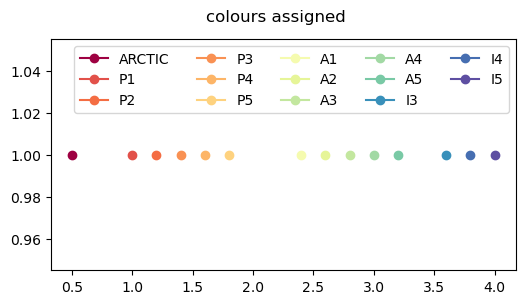

In [4]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan


# w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
# cbar = plt.colorbar(w, ticks=tics)
# t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
# plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('colours assigned')

In [5]:
regs_g = regs.copy()
regs_g.append('GLOBAL')
print(regs_g)

['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5', 'GLOBAL']


# Extract model data

    modlist = ['TOM12_TJ_GEA0', 'TOM12_DW_GA01','TOM12_DW_WE43']

    1.

In [6]:
import glob

def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

baseDir = '/gpfs/data/greenocean/software/runs/'
tr = 'TOM12_TJ_GEA0'
yrst = 1990
yrend = 1995
dtype = 'ptrc'

tylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)

tdat_GEA0 = xr.open_mfdataset(tylist)

In [7]:
tr = 'TOM12_DW_GA01'
yrst = 1990
yrend = 1995
dtype = 'ptrc'
tylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
tdat_GA01 = xr.open_mfdataset(tylist)


tr = 'TOM12_DW_WE43'
yrst = 1990
yrend = 1995
dtype = 'ptrc'
tylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
tdat_WE43 = xr.open_mfdataset(tylist)

In [8]:
print(tdat_GEA0.head(5))

<xarray.Dataset>
Dimensions:               (y: 5, x: 5, deptht: 5, time_counter: 5,
                           axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(5, 5), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(5, 5), meta=np.ndarray>
  * deptht                (deptht) float32 5.0 15.0 25.0 35.01 45.01
    time_centered         (time_counter) object dask.array<chunksize=(5,), meta=np.ndarray>
  * time_counter          (time_counter) object 1990-01-16 12:00:00 ... 1990-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/34)
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 dask.array<chunksize=(5, 5, 2), meta=np.ndarray>
    Alkalini              (time_counter, deptht, y, x) float32 dask.array<chunksize=(5, 5, 5, 5), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(5, 2), meta=np.ndarray>
    time_counter_bounds  

    2.

In [9]:
# reload(lom)

In [10]:
# tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
# depths = (tmesh['gdept_1d'][0])

In [11]:
# fig, axs = plt.subplots(4,4, figsize=(20*fact, 20*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()


# for i in range(0,len(regs)):
#     axs[i+1].plot(tdat_GA01['DIC'], -depths,color = 'k', label = f'TOM12_TJ_GEA0 \n ?')
# # axs[0].plot(np.arange(1,13,1), tmod['DIC'], color = 'k', label = '?')
# # for i in range(0,len(regs)):
# #     axs[i+1].plot(np.arange(1,13,1), tmod['mldr10_1'][i,:], color = 'k', linestyle = ':')
# # axs[0].plot(np.arange(1,13,1), tmod['mldr10_1'][14,:], color = 'k', linestyle = ':')


In [12]:
# fact = 0.8
# yst = 1955; yen = 1960
# xl1 = 1; xl2 = 12
# yl1 = 0; yl2 = 220
# stit = f'between-model MLD, years = {yst}-{yen} (solid line - mldkz5, dotted is mldr10_1)'

# fig, axs = plt.subplots(4,4, figsize=(20*fact, 20*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# # modlist = ['TOM12_TJ_GEA0', 'TOM12_DW_GA01','TOM12_DW_WE43']

# # 
# # 
# # 


# axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
# axs[15].set_xticklabels([])
# axs[15].set_yticklabels([])
# axs[0].text(xl1+0.35*(xl2-xl1),yl1+0.75*(yl2-yl1),'GLOBAL', color = 'k', fontsize = 16)


# for i in range(0,len(regs)):
#     axs[i+1].plot(xl1+0.2*(xl2-xl1),yl1+0.8*(yl2-yl1),marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
#     axs[i+1].text(xl1+0.35*(xl2-xl1),yl1+0.75*(yl2-yl1),regs[i], color = 'k', fontsize = 16)
# for i in range(0,len(regs)+1):
#     axs[i].set_xlim([xl1, xl2])
#     axs[i].set_ylim([-yl1,yl2])
#     axs[i].set_xticks(np.arange(1,13,1))
    
#     axs[i].grid()
# axs[3].legend(fontsize = 10, bbox_to_anchor = [1,1])

# plt.suptitle(stit, fontsize = 20, y = 0.98)
# plt.tight_layout()

# 1990-2020 trend, surface, DIC, ALK

In [13]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:] # area of grid cells
csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

In [16]:
## weighted mean DIC

DIC_ts_GEA0 = tdat_GEA0.DIC.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y']) #surface DIC
TA_ts_GEA0 = tdat_GEA0.Alkalini.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y'])

DIC_ts_GA01 = tdat_GA01.DIC.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y']) #surface DIC
TA_ts_GA01 = tdat_GA01.Alkalini.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y'])

DIC_ts_WE43 = tdat_WE43.DIC.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y']) #surface DIC
TA_ts_WE43 = tdat_WE43.Alkalini.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y'])

Text(0.5, 1.0, '1990-2020 Surface DIC, umol/L')

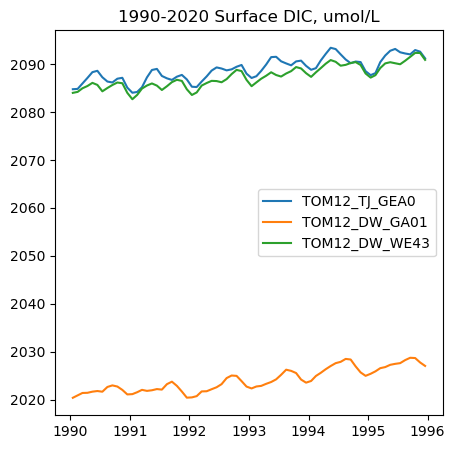

In [24]:
scal = 1
plt.figure(figsize=(5*scal, 5*scal))

dtimes = DIC_ts_GEA0.indexes['time_counter'].to_datetimeindex()
plt.plot(dtimes, DIC_ts_GEA0*1e6, label = 'TOM12_TJ_GEA0')

dtimes = DIC_ts_GA01.indexes['time_counter'].to_datetimeindex()
plt.plot(dtimes, DIC_ts_GA01*1e6, label = 'TOM12_DW_GA01')

dtimes = DIC_ts_WE43.indexes['time_counter'].to_datetimeindex()
plt.plot(dtimes, DIC_ts_WE43*1e6, label = 'TOM12_DW_WE43')
plt.legend()
plt.title('1990-2020 Surface DIC, umol/L')

Text(0.5, 1.0, '1990-2020 Surface Alkalini, umol/L')

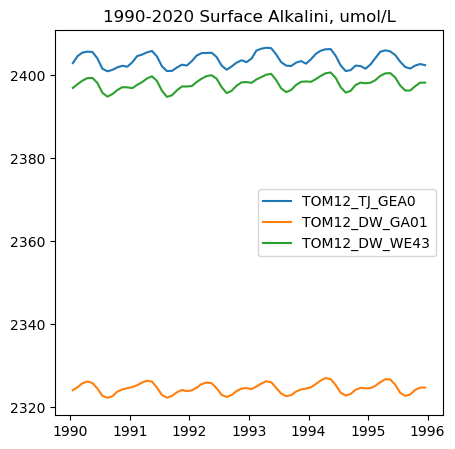

In [26]:
scal = 1
plt.figure(figsize=(5*scal, 5*scal))

dtimes = TA_ts_GEA0.indexes['time_counter'].to_datetimeindex()
plt.plot(dtimes, TA_ts_GEA0*1e6, label = 'TOM12_TJ_GEA0')

dtimes = TA_ts_GA01.indexes['time_counter'].to_datetimeindex()
plt.plot(dtimes, TA_ts_GA01*1e6, label = 'TOM12_DW_GA01')

dtimes = TA_ts_WE43.indexes['time_counter'].to_datetimeindex()
plt.plot(dtimes, TA_ts_WE43*1e6, label = 'TOM12_DW_WE43')
plt.legend()
plt.title('1990-2020 Surface Alkalini, umol/L')

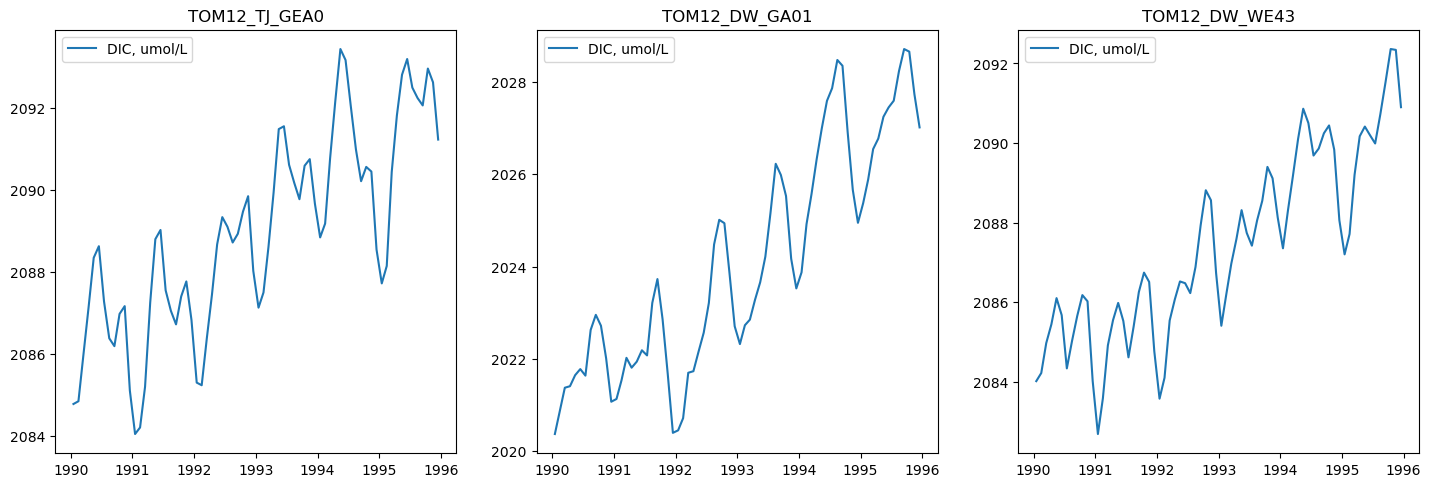

In [19]:
#multiply by 1e6 to get from mol/L to micromol/L 
# 'TOM12_TJ_GEA0', 'TOM12_DW_GA01','TOM12_DW_WE43'

scal = 1.1
fig, axs = plt.subplots(1,3, figsize=(16*scal, 5*scal), facecolor='w', edgecolor='k')
axs = axs.ravel()

dtimes = DIC_ts_GEA0.indexes['time_counter'].to_datetimeindex()
axs[0].plot(dtimes, DIC_ts_GEA0*1e6, label = 'DIC, umol/L')
axs[0].set_title(r'TOM12_TJ_GEA0')
axs[0].legend()

dtimes = DIC_ts_GA01.indexes['time_counter'].to_datetimeindex()
axs[1].plot(dtimes, DIC_ts_GA01*1e6, label = 'DIC, umol/L')
axs[1].set_title(r'TOM12_DW_GA01')
axs[1].legend()

dtimes = DIC_ts_WE43.indexes['time_counter'].to_datetimeindex()
axs[2].plot(dtimes, DIC_ts_WE43*1e6, label = 'DIC, umol/L')
axs[2].set_title(r'TOM12_DW_WE43')
axs[2].legend()





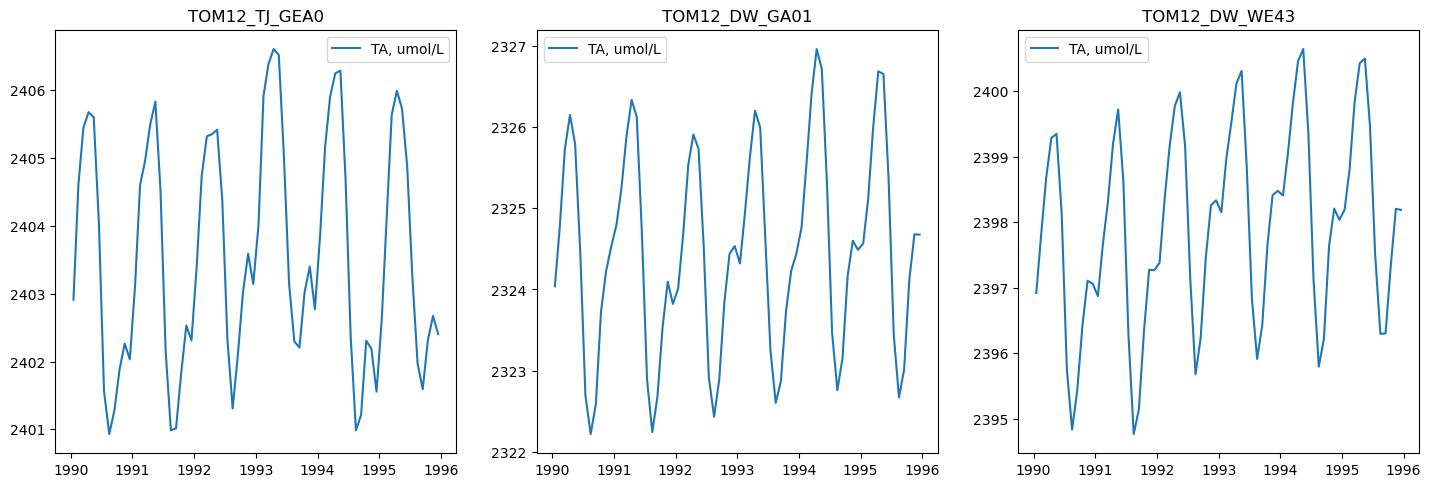

In [28]:

scal = 1.1
fig, axs = plt.subplots(1,3, figsize=(16*scal, 5*scal), facecolor='w', edgecolor='k')
axs = axs.ravel()

dtimes = TA_ts_GEA0.indexes['time_counter'].to_datetimeindex()
axs[0].plot(dtimes, TA_ts_GEA0*1e6, label = 'TA, umol/L')
axs[0].set_title(r'TOM12_TJ_GEA0')
axs[0].legend()

dtimes = TA_ts_GA01.indexes['time_counter'].to_datetimeindex()
axs[1].plot(dtimes, TA_ts_GA01*1e6, label = 'TA, umol/L')
axs[1].set_title(r'TOM12_DW_GA01')
axs[1].legend()

dtimes = TA_ts_WE43.indexes['time_counter'].to_datetimeindex()
axs[2].plot(dtimes, TA_ts_WE43*1e6, label = 'TA, umol/L')
axs[2].set_title(r'TOM12_DW_WE43')
axs[2].legend()